In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import mobilenet, resnet_v2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint

In [21]:
tf.test.is_gpu_available()

True

In [22]:
dataset_path = Path("../inputs/common-mobile-web-app-icons/archive")

In [23]:
image_paths = [path for path in dataset_path.glob("*/*.jpg")]
len(image_paths)

153378

In [24]:
[path for path in dataset_path.glob("*/*.svg")]

[WindowsPath('../inputs/common-mobile-web-app-icons/archive/save/download.svg')]

In [25]:
x_col_name = "image_path"
y_col_name = "class"
df = pd.DataFrame({x_col_name: image_paths})
df[y_col_name] = df[x_col_name].map(lambda x: x.parent.stem)
df[x_col_name] = df[x_col_name].map(lambda x: str(x))

In [26]:
df.head()

,image_path,class
0,..\inputs\common-mobile-web-app-icons\archive\...,add
1,..\inputs\common-mobile-web-app-icons\archive\...,add
2,..\inputs\common-mobile-web-app-icons\archive\...,add
3,..\inputs\common-mobile-web-app-icons\archive\...,add
4,..\inputs\common-mobile-web-app-icons\archive\...,add


In [27]:
USE_LABELS = ['arrow_left', 'notifications', 'play', 'info', 'mail',
              'globe', 'upload', 'music', 'close', 'user', 'settings', 'home',
              'fast_forward', 'trash', 'question', 'map', 'eye', 'check_mark',
              'sort', 'overflow_menu', 'minimize', 'save', 'delete',
              'maximize', 'download', 'share', 'external_link', 'thumbs_up',
              'search', 'arrow_right', 'crop', 'camera', 'refresh', 'add',
              'volume', 'favorite', 'menu', 'edit', 'fab', 'link', 'arrow_up',
              'arrow_down', 'tag', 'warning', 'bookmark', 'cart', 'cloud',
              'filter', '_negative']

In [8]:
USE_LABELS = ['add','alarm','arrow_right']

In [28]:
labels = set(df[y_col_name].unique()).difference(set(USE_LABELS))
print(labels)
drop_indexes = pd.Index([])
for label in labels:
    drop_index = df[df[y_col_name] == label].index
    drop_indexes = drop_indexes.union(drop_index)

{'location', 'fingerprint', 'facebook', 'google', 'inbox', 'clock', 'send', 'credit_card', 'laptop', 'ticket', 'bag', 'unlock', 'file', 'microphone', 'printer', 'profile_avatar', 'flashlight', 'gift', 'headphones', 'lock', 'attach', 'car', 'dollar', 'calendar', 'pinterest', 'mute', 'rewind', 'video_camera', 'fire', 'computer', 'chart', 'barcode', 'megaphone', 'signal', 'light_bulb', 'gmail', 'contrast', 'calculator', 'trophy', 'flag', 'twitter', 'cut', 'bluetooth', 'qr_code', 'battery', 'airplane', 'call', 'brightness', 'dashboard', 'alarm', 'folder', 'cursor', 'reply', 'moon', 'grid', 'television', 'mobile'}


In [29]:
df.drop(index=drop_indexes, inplace=True)

In [30]:
df.shape

(82046, 2)

In [31]:
#df = df.sample(n=60000)
#df.shape

In [32]:
test_size = 0.2
random_state = 1234
x_train, x_val, y_train, y_val = train_test_split(df[x_col_name], df[y_col_name],
                                                      test_size=test_size,
                                                      shuffle=True,
                                                      random_state=random_state,
                                                      stratify=df[y_col_name])

In [33]:
num_classes = len(df[y_col_name].unique())
num_classes

49

In [34]:
def plot_history(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

In [35]:
def build_model(base_model, n_classes):
#     base_model.trainable = False
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(1024, activation="relu")(x)
    x = Dropout(0.25)(x)
    x = Dense(512, activation="relu")(x)
    x = Dropout(0.25)(x)
    y = Dense(n_classes, activation="softmax")(x)

    model = Model(inputs=base_model.input,
                  outputs=y)
    return model

In [36]:
width, height = 224, 224
target_size = (height, width)
num_channels = 3
input_shapes = (height, width, num_channels)
epochs = 8
lr = 0.001
batch_size = 16
opt = optimizers.Adam(lr=lr)

C:\Users\15091\Anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [37]:
base_model = resnet_v2.ResNet101V2(include_top=False,
                                   weights='imagenet',
                                   input_shape=input_shapes)

In [38]:
model = build_model(base_model, num_classes)
#model.summary()

In [39]:
filepath = "Test.{epoch:02d}-{val_loss:.2f}.hdf5"
callbacks = [ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True)]

In [40]:
epochs = 10

In [41]:
model = keras.models.load_model('Test.03-1.08.hdf5')

OSError: No file or directory found at Test.03-1.08.hdf5

In [42]:
train_gen = ImageDataGenerator(#rotation_range=45,
                               width_shift_range=.15,
                               height_shift_range=.15,
                               #horizontal_flip=True,
                               zoom_range=0.5,
                               preprocessing_function=resnet_v2.preprocess_input)
train_generator = train_gen.flow_from_dataframe(
        pd.concat([x_train, y_train],
                  axis=1),
        x_col=x_col_name,
        y_col=y_col_name,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training')
valid_gen = ImageDataGenerator(preprocessing_function=resnet_v2.preprocess_input)
valid_generator = valid_gen.flow_from_dataframe(pd.concat([x_val, y_val],
                                                              axis=1),
                                                    x_col=x_col_name,
                                                    y_col=y_col_name,
                                                    target_size=target_size,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    subset='training')
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator,
                              validation_steps=STEP_SIZE_VALID,
                              epochs=epochs,
                              callbacks=callbacks)

Found 65636 validated image filenames belonging to 49 classes.
Found 16410 validated image filenames belonging to 49 classes.


C:\Users\15091\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/10
4102/4102 [==============================] - ETA: 0s - loss: 3.1654 - accuracy: 0.2137

C:\Users\15091\Anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


4102/4102 [==============================] - 2409s 582ms/step - loss: 3.1654 - accuracy: 0.2137 - val_loss: 5.8938 - val_accuracy: 0.2026
Epoch 2/10
4102/4102 [==============================] - 2294s 559ms/step - loss: 2.1247 - accuracy: 0.4717 - val_loss: 1.9085 - val_accuracy: 0.5361
Epoch 3/10
4102/4102 [==============================] - 2439s 594ms/step - loss: 1.3757 - accuracy: 0.6577 - val_loss: 1.0382 - val_accuracy: 0.7430
Epoch 4/10
4102/4102 [==============================] - 2482s 605ms/step - loss: 1.1018 - accuracy: 0.7246 - val_loss: 0.8816 - val_accuracy: 0.7789
Epoch 5/10
4102/4102 [==============================] - 2509s 612ms/step - loss: 0.9631 - accuracy: 0.7598 - val_loss: 0.7184 - val_accuracy: 0.8194
Epoch 6/10
4102/4102 [==============================] - 2577s 628ms/step - loss: 0.8800 - accuracy: 0.7777 - val_loss: 0.6619 - val_accuracy: 0.8326
Epoch 7/10
4102/4102 [==============================] - 2507s 611ms/step - loss: 0.8152 - accuracy: 0.7944 - val_loss

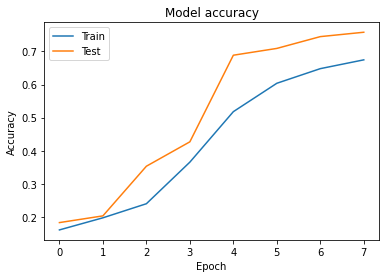

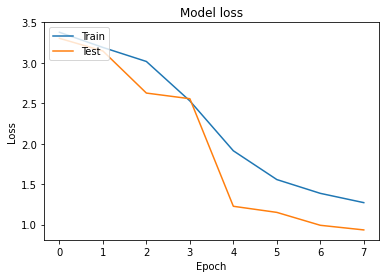

In [26]:
plot_history(history)

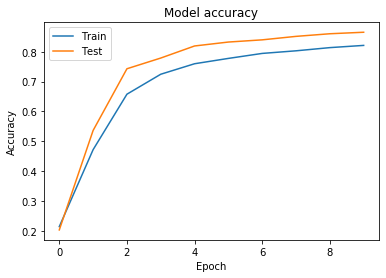

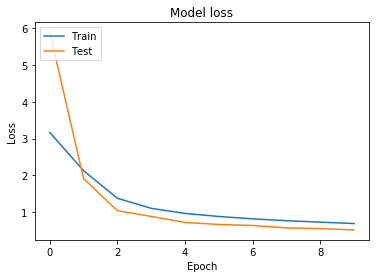

In [43]:
plot_history(history)